# Notebook 3 – Training NeuLib architectures from scratch

In this notebook we move from using pretrained models to **training a NeuLib architecture from scratch** on ECG data.

Main storyline:

- Configure a GRU-based seq2seq architecture for peak detection.
- Train the model from scratch on a small ECG dataset.
- Evaluate its performance on test segments.
- Continue training the same model for a few extra epochs.

In a later branch of this notebook, we will also:
- Run a small **grid search** over hyperparameters to explore different architectures.

## Step 0 – Setup and data

We first:

- Import NeuLib architectures and utility functions.
- Point to the ECG dataset prepared for peak detection:
  - `X`: input ECG segments
  - `Y`: binary labels or target sequences


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

import sys

# Add the project directory to sys.path
project_path = os.path.abspath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

from NeuralLib.config import DATASETS_ECG_G
import NeuralLib.architectures as archs


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X = os.path.join(DATASETS_ECG_G, 'sample', 'x')
Y = os.path.join(DATASETS_ECG_G, 'sample', 'y_bin')

## Part A – One model from scratch

Before exploring many combinations, we start with **one concrete model**:

1. Inspect which architectures are available in NeuLib.
2. Choose `GRUseq2seq` for ECG peak detection.
3. Define a *single* configuration of hyperparameters.
4. Train, test and continue training this model.


### Available architectures in NeuLib

NeuLib includes several biosignal-oriented architectures:

- GRU encoder–decoder and seq2seq
- Transformer-based encoder–decoder and seq2seq
- Sequence-to-one and sequence-to-sequence variants

For this tutorial we will use **GRUseq2seq**, which is well suited for:

- Peak detection over ECG segments
- Denoising and regression tasks


#### List all the available architectures from Lib

In [3]:
# To check which classes of architectures are available
from NeuralLib.architectures import list_architectures
list_architectures()

['GRUED',
 'GRUseq2one',
 'GRUseq2seq',
 'TransformerED',
 'Transformerseq2one',
 'Transformerseq2seq']

### Step 1 – Define a single GRUseq2seq configuration

To keep the first run simple, we choose:

- A moderate hidden dimension and number of layers.
- Dropout for regularisation.
- A binary **classification** task for peak detection.

This mirrors how pretrained peak-detector models in NeuLib were originally trained,
but here we run a small training loop live.


In [4]:
personal_params = {
    'model_name': 'ECGPeakDetector',
    'n_features': 1,
    'hid_dim': 16,
    'n_layers': 2,
    'dropout': 0.3,
    'learning_rate': 0.01,
    'bidir_per_layer': [True, False], # Example for 2 layers
    'task': 'classification',
    'num_classes': 1,
    }

In [5]:
personal_model = archs.GRUseq2seq(**personal_params)
print(personal_model)

GRUseq2seq(
  (gru_layers): ModuleList(
    (0): GRU(1, 16, batch_first=True, bidirectional=True)
    (1): GRU(32, 16, batch_first=True)
  )
  (dropout_layers): ModuleList(
    (0-1): 2 x Dropout(p=0.3, inplace=False)
  )
  (fc_out): Linear(in_features=16, out_features=1, bias=True)
  (criterion): BCEWithLogitsLoss()
)


### Step 2 – Training parameters

We now specify:

- Number of epochs and batch size (kept small for the demo).
- Dataset name and task description (stored in the training metadata).
- Device configuration (CPU for portability during the tutorial).

The `train_from_scratch` method will use these parameters
to run a full training loop.


In [6]:
# Minimal values for testing purposes
train_params = {
    'path_x': X,
    'path_y': Y,
    'epochs': 3,
    'batch_size': 1,
    'patience': 2,
    'dataset_name': 'private_gib01',
    'trained_for': 'peak detection',
    'all_samples': False,
    'samples': 3,
    'gpu_id': None,
    'enable_tensorboard': True
}

### Step 3 – Train from scratch

We call:

```python
model_personal.train_from_scratch(**train_params)


In [7]:
final_weight_path = personal_model.train_from_scratch(**train_params)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_chec

No GPU available, using CPU.
Checkpoints directory created at /Users/groupies/Documents/NOVAProjects/NeuralLib-fork/results/ECGPeakDetector/checkpoints/GRUseq2seq_[16, 16]hid_2l_lr0.01_drop[0.3, 0.3]_dt2026-02-12_15-48-38
✅ Dataset validation passed.
✅ Dataset validation passed.
Starting training...
Sanity Checking DataLoader 0:   0%|       | 0/2 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|█| 3/3 [00:10<00:00,  0.28it/s, v_num=0, train_los
idation: |                             | 0/? [00:00<?, ?it/s]
idation: |                             | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████| 3/3 [00:00<00:00,  3.75it/s]
Epoch 1: 100%|█| 3/3 [00:10<00:00,  0.29it/s, v_num=0, train_los
idation: |                             | 0/? [00:00<?, ?it/s]
idation: |                             | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████| 3/3 [00:00<00:00,  3.67it/s]
Epoch 2: 100%|█| 3/3 [00:10<00:00,  0.28it/s, v_num=0, train_los
idation: |                             | 0/? [00:00<?, ?it/s]
idation: |                             | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████| 3/3 [00:00<00:00,  3.75it/s]
Epoch 2: 100%|█| 3/3 [00:11<00:00,  0.26it/s, v_num=0, train_los

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|█| 3/3 [00:11<00:00,  0.26it/s, v_num=0, train_los
Total training time: 34.74 seconds
{'architecture': 'GRUseq2seq', 'model_name': 'ECGPeakDetector', 'train_dataset': 'private_gib01', 'task': 'peak detection', 'gpu_model': None, 'epochs': 3, 'optimizer': 'Adam (\nParameter Group 0\n    amsgrad: False\n    betas: (0.9, 0.999)\n    capturable: False\n    decoupled_weight_decay: False\n    differentiable: False\n    eps: 1e-08\n    foreach: None\n    fused: None\n    initial_lr: 0.01\n    lr: 0.01\n    maximize: False\n    weight_decay: 1e-05\n)', 'learning_rate': 0.01, 'validation_loss': 0.0496881902217865, 'training_time': 34.74196791648865, 'retraining': False, 'efficiency_flops': None, 'efficiency_params': 4241}
Training complete. Best_model_path: /Users/groupies/Documents/NOVAProjects/NeuralLib-fork/results/ECGPeakDetector/checkpoints/GRUseq2seq_[16, 16]hid_2l_lr0.01_drop[0.3, 0.3]_dt2026-02-12_15-48-38/GRUseq2seq_[16, 16]hid_2l_lr0.01_drop[0.3, 0.3].ckpt
Weights saved 

### Step 4 – Evaluate on test segments

After training, we can:

- Run `test_on_test_set` to obtain aggregate metrics.
- Use `test_on_single_signal` to get a single prediction
  - Then you could do whatever you want to fit your requirement


In [8]:
predictions, avg_loss = personal_model.test_on_test_set(
    path_x=train_params["path_x"],
    path_y=train_params["path_y"],
    checkpoints_dir=final_weight_path,
    gpu_id=train_params["gpu_id"],
    save_predictions=True,
    all_samples=False,
    samples=5,
)

No GPU available, using CPU.
Using device: cpu
✅ Dataset validation passed.
Weights successfully loaded from /Users/groupies/Documents/NOVAProjects/NeuralLib-fork/results/ECGPeakDetector/checkpoints/GRUseq2seq_[16, 16]hid_2l_lr0.01_drop[0.3, 0.3]_dt2026-02-12_15-48-38/model_weights.pth.
Sample 0: Test Loss: 0.0492
Sample 1: Test Loss: 0.0492
Sample 2: Test Loss: 0.0500
Sample 3: Test Loss: 0.0499
Sample 4: Test Loss: 0.0499
Average Test Loss: 0.0497


In [10]:
single_signal = torch.rand(100, 1)  # Example input signal (sequence length: 100, 1 feature)
signal_prediction = personal_model.test_on_single_signal(single_signal, checkpoints_dir=final_weight_path, gpu_id=train_params["gpu_id"])
print(f"Single Signal Prediction: {signal_prediction}")

No GPU available, using CPU.
Using device: cpu
Weights successfully loaded from /Users/groupies/Documents/NOVAProjects/NeuralLib-fork/results/ECGPeakDetector/checkpoints/GRUseq2seq_[16, 16]hid_2l_lr0.01_drop[0.3, 0.3]_dt2026-02-12_15-48-38/model_weights.pth.
Single Signal Prediction: tensor([[[-1.5471],
         [-2.2610],
         [-2.6396],
         [-2.8546],
         [-2.9851],
         [-3.0759],
         [-3.1339],
         [-3.1765],
         [-3.2075],
         [-3.2301],
         [-3.2508],
         [-3.2665],
         [-3.2788],
         [-3.2888],
         [-3.2956],
         [-3.3016],
         [-3.3054],
         [-3.3087],
         [-3.3104],
         [-3.3151],
         [-3.3185],
         [-3.3221],
         [-3.3228],
         [-3.3243],
         [-3.3273],
         [-3.3283],
         [-3.3294],
         [-3.3312],
         [-3.3318],
         [-3.3336],
         [-3.3352],
         [-3.3361],
         [-3.3368],
         [-3.3367],
         [-3.3369],
         [-3.33

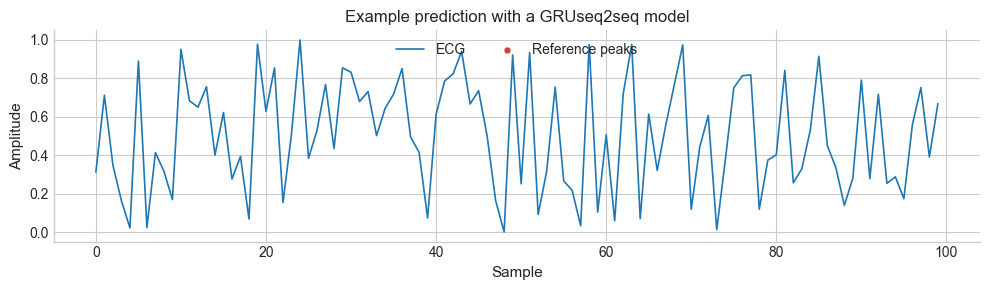

In [11]:
# Visualize testing result
plt.style.use("seaborn-v0_8-whitegrid")

fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(single_signal, color="#1f77b4", linewidth=1.2, label="ECG")

peak_indices = np.where(signal_prediction > 0.5)[0]
ax.scatter(
    peak_indices,
    single_signal[peak_indices],
    facecolors="#d62728",
    edgecolors="white",
    s=25,
    alpha=0.9,
    linewidth=0.4,
    zorder=3,
    label="Reference peaks",
)

ax.set_title("Example prediction with a GRUseq2seq model", fontsize=12)
ax.set_xlabel("Sample", fontsize=11)
ax.set_ylabel("Amplitude", fontsize=11)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(
    loc="upper center",
    ncol=2,
    frameon=False,
    fontsize=10,
)

plt.tight_layout()
plt.show()

### Step 5 – Continue training the same model

Instead of starting from scratch again, we can:

- Reload the best checkpoint, or
- Directly call a **retraining** / **continue_training** method on the same model.

Typical use cases:

- Extending training for a few extra epochs.
- Adapting the model after we collect more data from the same domain.

The next cell shows how to run a short extra training phase
and observe whether the validation loss still improves.


In [78]:
# Example: reusing train_params with a small number of extra epochs
# retrain the model using the best found parameters
train_params_retrain = train_params.copy()
train_params_retrain['epochs'] = 4
personal_model.retrain(
    checkpoints_directory=final_weight_path, # checkpoints directory where the models weights and parameters were stored in the previous step
    path_x=train_params_retrain['path_x'],
    path_y=train_params_retrain['path_y'],
    patience=train_params_retrain['patience'],
    batch_size=train_params_retrain['batch_size'],
    epochs=train_params_retrain['epochs'],
    gpu_id=train_params_retrain['gpu_id'],
    all_samples=train_params_retrain['all_samples'],
    samples=train_params_retrain['samples'],
    dataset_name=train_params_retrain['dataset_name'],
    trained_for=train_params_retrain['trained_for'],
    enable_tensorboard=train_params_retrain['enable_tensorboard'],
)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /Users/groupies/Documents/NOVAProjects/NeuralLib-fork/results/ECGPeakDetector/checkpoints/GRUseq2seq_[16, 16]hid_2l_lr0.01_drop[0.3, 0.3]_retraining_dt2026-02-12_14-31-19 exists and is not empty.

  | Name           | Type              | Params | Mode
------------------------------------------------------------
0 | gru_layers     | ModuleList        | 4.2 K  | eval
1 | dropout_layers | ModuleList        | 0      | eval
2 | fc_out         | Linear            | 17     | eval
3 | criterion      | BCEWithLogitsLoss | 0      | eval
------------------------------------------------------------
4.2 K     Trainable params
0         Non-trainable params
4.2 K     Total params
0.017     Total estimated model params size (MB)
0     

No GPU available, using CPU.
Found existing .pth file: /Users/groupies/Documents/NOVAProjects/NeuralLib-fork/results/ECGPeakDetector/checkpoints/GRUseq2seq_[16, 16]hid_2l_lr0.01_drop[0.3, 0.3]_dt2026-02-12_14-30-48/model_weights.pth
Weights loaded successfully from /Users/groupies/Documents/NOVAProjects/NeuralLib-fork/results/ECGPeakDetector/checkpoints/GRUseq2seq_[16, 16]hid_2l_lr0.01_drop[0.3, 0.3]_dt2026-02-12_14-30-48/model_weights.pth
✅ Dataset validation passed.
✅ Dataset validation passed.
Epoch 0: 100%|██████| 3/3 [00:09<00:00,  0.31it/s, v_num=0, train_loss=0.0286]
idation: |                                           | 0/? [00:00<?, ?it/s]
idation: |                                           | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|██████████████████| 3/3 [00:00<00:00,  5.21it/s]
Epoch 1: 100%|█| 3/3 [00:09<00:00,  0.31it/s, v_num=0, train_loss=0.0285, val_
idation: |                                           | 0/? [00:00<?, ?it/s]
idation: |                          

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|█| 3/3 [00:10<00:00,  0.28it/s, v_num=0, train_loss=0.0285, val_
Total training time: 41.90 seconds
{'architecture': 'GRUseq2seq', 'model_name': 'ECGPeakDetector', 'train_dataset': 'private_gib01', 'task': 'peak detection', 'gpu_model': None, 'epochs': 4, 'optimizer': 'Adam (\nParameter Group 0\n    amsgrad: False\n    betas: (0.9, 0.999)\n    capturable: False\n    decoupled_weight_decay: False\n    differentiable: False\n    eps: 1e-08\n    foreach: None\n    fused: None\n    initial_lr: 0.01\n    lr: 0.01\n    maximize: False\n    weight_decay: 1e-05\n)', 'learning_rate': 0.01, 'validation_loss': 0.028083553537726402, 'training_time': 41.89787173271179, 'retraining': True, 'efficiency_flops': None, 'efficiency_params': 4241, 'training_history': {'architecture': 'GRUseq2seq', 'model_name': 'ECGPeakDetector', 'train_dataset': 'private_gib01', 'task': 'peak detection', 'gpu_model': None, 'epochs': 3, 'optimizer': 'Adam (\nParameter Group 0\n    amsgrad: False\n    betas: 

## Part B – Exploring architectures with grid search

Once we have seen one model trained end-to-end,
we can explore a small hyperparameter space:

- Different hidden dimensions and numbers of layers.
- Alternative dropout values.
- Potentially different bidirectionality patterns.

NeuLib provides a simple `grid_search` utility that:

- Iterates over combinations of architecture hyperparameters.
- Trains a model for each combination (with limited epochs in this demo).
- Logs validation loss and basic efficiency statistics.


In [52]:
architecture_name = 'GRUseq2seq'
archs.validate_architecture_name(architecture_name)

archi_params_options = {
    "model_name": "ECGPeakDetector",
    "n_features": [1],
    "hid_dim": [[32, 64, 64], [64, 64, 64], [64, 128, 64], [64, 128]],
    "n_layers": [3, 2],
    "dropout": [0.3, 0],
    "learning_rate": [0.001],
    "bidirectional": [True],
    "task": ["classification"],
    "num_classes": [1],
}

Architecture GRUseq2seq is valid.


In [53]:
train_params = {
    'path_x': X,
    'path_y': Y,
    'epochs': 2,
    'batch_size': 1,
    'patience': 2,
    'dataset_name': 'private_test',
    'trained_for': 'peak detection',
    'all_samples': False,
    'samples': 3,
    'gpu_id': None,
    'enable_tensorboard': True,
}

#### Step 2: Perform grid search

In [ ]:
best_dir, best_val_loss, val_losses = archs.run_grid_search(architecture_name, archi_params_options, train_params)

### Step 3: Test the Best model performance on your test set

In [ ]:
# Load architecture parameters from the best checkpoints directory
architecture_params = archs.get_hparams_from_checkpoints(best_dir)
# Initialize the model with the best architecture parameters
model = archs.GRUseq2seq(**architecture_params)

predictions, avg_loss = model.test_on_test_set(
    path_x=train_params["path_x"],
    path_y=train_params["path_y"],
    checkpoints_dir=best_dir,
    gpu_id=train_params["gpu_id"],
    save_predictions=True,
    all_samples=False,
    samples=5,
)

## Try other architectures to fit your tasks
You can change `architecture_name` to any of the entries listed above and re-run the cells that instantiate, train and evaluate the model.
